In [26]:
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade

In [27]:
# Libraries
# ==============================================================================
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import  ForecasterAutoregMultiOutput
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals
from skforecast.model_selection import grid_search_forecaster
%config Completer.use_jedi = False


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

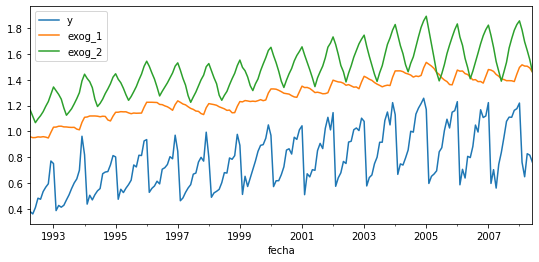

In [ ]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

# ForecasterAutoreg

## ForecasterAutoreg without exogenous variables

In [9]:
forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 5
             )
forecaster

<class 'skforecast.ForecasterAutoreg.ForecasterAutoreg'> 
Regressor: Ridge() 
Lags: [1 2 3 4 5] 
Window size: 5 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequancy: None 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 

In [10]:
# Cross-validation forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 5
             )

metric, predictions_cv = cv_forecaster(
                            forecaster  = forecaster,
                            y           = data.y,
                            steps       = 10,
                            metric      = 'mean_squared_error',
                            initial_train_size    = int(len(data)*0.5),
                            allow_incomplete_fold = True,
                            verbose     = True
                        )
print(f"Error de backtest: {metric}")
predictions_cv

Number of folds: 10
Since `allow_incomplete_fold=True`, last fold only includes 8 observations instead of 10. 

Incomplete folds with few observations could overestimate or  underestimate validation metrics. 

Error de backtest: [0.05315735 0.05103496 0.04601912 0.0322163  0.0699501  0.10891208
 0.08879838 0.06135912 0.06047377 0.03086596]


2000-05-01    0.589944
2000-06-01    0.611775
2000-07-01    0.654139
2000-08-01    0.667826
2000-09-01    0.677431
                ...   
2008-02-01    0.810465
2008-03-01    0.783701
2008-04-01    0.771635
2008-05-01    0.768880
2008-06-01    0.771527
Freq: MS, Name: pred, Length: 98, dtype: float64

In [11]:
# Backtest forecaster with initial train
# ==============================================================================
steps = 36
n_backtest = 36 * 3 + 1 # Last 3 months are used for backtest
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 5
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data_train),
                                    steps      = steps,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
predictions_backtest

Number of observations used for training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
Error de backtest: [0.09599272]


1999-06-01    0.633158
1999-07-01    0.658656
1999-08-01    0.660872
1999-09-01    0.665493
1999-10-01    0.661749
                ...   
2008-02-01    0.654481
2008-03-01    0.654480
2008-04-01    0.654480
2008-05-01    0.654480
2008-06-01    0.655354
Freq: MS, Name: pred, Length: 109, dtype: float64

In [12]:
# Comprobación manual
# ==============================================================================
forecaster.fit(y=data_train.y)
predictions_1 = forecaster.predict(steps=steps)
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2])
predictions_4 = forecaster.predict(steps=1, last_window=data_test.y[steps*2:steps*3])
(predictions_backtest == np.concatenate([predictions_1, predictions_2,
                                         predictions_3, predictions_4])).all()

True

In [13]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 15 
             )

forecaster.fit(y=data.y)

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = None,
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")

root       WARNING Altough no initial train is done, the first 15 observations are needed to create the initial predictors. Therefore, no predictions are calculated for them.


Number of observations used for training or as initial window: 15
Number of observations used for backtesting: 180
    Number of folds: 18
    Number of steps per fold: 10
Error de backtest: [0.0046328]


In [18]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=Ridge(),
                lags=12
             )

# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(data)*0.5),
                        allow_incomplete_fold = True,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid.head(3)

root       INFO  Number of models compared: 9
loop param_grid:   0%|                                    | 0/3 [00:00<?, ?it/s]
                                                                                
loop lags_grid: 100%|█████████████████████████████| 3/3 [00:00<00:00, 16.25it/s]
root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'alpha': 0.01}



,lags,params,metric,alpha
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 0.01},0.042367,0.01
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 0.1},0.043386,0.10
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 1},0.054920,1.00


In [15]:
# Backtest with intervals ForecasterAutoreg with initial train
# ==============================================================================
n_backtest = 36*3 + 1 # Last 3 months are used for backtest
steps = 36
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 5 
             )

metric, predictions_backtest = backtesting_forecaster_intervals(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data_train),
                                    steps      = steps,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
predictions_backtest.head(3)

Number of observations used for training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
Error de backtest: [0.09599272]


,pred,lower_bound,upper_bound
1999-06-01,0.633158,0.398868,0.895830
1999-07-01,0.658656,0.426666,0.859379
1999-08-01,0.660872,0.416290,0.874387


In [16]:
# Backtest with intervals ForecasterAutoreg without initial train (forecaster already trained)
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 15 
             )

forecaster.fit(y=data.y)

metric, predictions_backtest = backtesting_forecaster_intervals(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = None,
                                    steps      = steps,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
predictions_backtest.head(3)

root       WARNING Altough no initial train is done, the first 15 observations are needed to create the initial predictors. Therefore, no predictions are calculated for them.


Number of observations used for training or as initial window: 15
Number of observations used for backtesting: 180
    Number of folds: 5
    Number of steps per fold: 36
Error de backtest: [0.00772651]


,pred,lower_bound,upper_bound
1993-07-01,0.530476,0.417159,0.637735
1993-08-01,0.554653,0.451082,0.669703
1993-09-01,0.606736,0.490569,0.722105


## ForecasterAutoreg with exogenous variables

In [11]:
forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 5
             )
forecaster

<class 'skforecast.ForecasterAutoreg.ForecasterAutoreg'> 
Regressor: Ridge() 
Lags: [1 2 3 4 5] 
Window size: 5 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequancy: None 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 

In [12]:
# Cross-validation forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 5
             )

metric, predictions_cv = cv_forecaster(
                            forecaster  = forecaster,
                            y           = data.y,
                            exog        = data[['exog_1', 'exog_2']],
                            steps       = 10,
                            metric      = 'mean_squared_error',
                            initial_train_size    = int(len(data)*0.5),
                            allow_incomplete_fold = True,
                            verbose     = True
                        )
print(f"Error de backtest: {metric}")
predictions_cv

Number of folds: 10
Since `allow_incomplete_fold=True`, last fold only includes 8 observations instead of 10. 

Incomplete folds with few observations could overestimate or  underestimate validation metrics. 

Error de backtest: [0.02885541 0.0196112  0.02556665 0.02631786 0.0370498  0.04818154
 0.02851857 0.00865066 0.0320114  0.02946661]


2000-05-01    0.604405
2000-06-01    0.637481
2000-07-01    0.708773
2000-08-01    0.741861
2000-09-01    0.762024
                ...   
2008-02-01    0.975279
2008-03-01    0.930381
2008-04-01    0.891543
2008-05-01    0.835290
2008-06-01    0.758883
Freq: MS, Name: pred, Length: 98, dtype: float64

In [13]:
# Backtest forecaster with initial train
# ==============================================================================
n_backtest = 36 * 3 + 1 # Last 3 months are used for backtest
steps = 36
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 5 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = len(data_train),
                                    steps      = steps,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
predictions_backtest

Number of observations used for training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
Error de backtest: [0.0529035]


1999-06-01    0.639071
1999-07-01    0.682442
1999-08-01    0.696648
1999-09-01    0.719612
1999-10-01    0.730112
                ...   
2008-02-01    0.827570
2008-03-01    0.785154
2008-04-01    0.749744
2008-05-01    0.717963
2008-06-01    0.681811
Freq: MS, Name: pred, Length: 109, dtype: float64

In [14]:
# Comprobación manual
# ==============================================================================
forecaster.fit(y=data_train.y, exog = data_train[['exog_1', 'exog_2']])
predictions_1 = forecaster.predict(
                    steps=steps,
                    exog=data_test.iloc[:steps, ].loc[ : ,['exog_1', 'exog_2']]
                )
predictions_2 = forecaster.predict(
                    steps=steps,
                    last_window=data_test.y[:steps],
                    exog=data_test.iloc[steps:steps*2].loc[ : ,['exog_1', 'exog_2']]
                )
predictions_3 = forecaster.predict(
                    steps=steps,
                    last_window=data_test.y[steps:steps*2],
                    exog=data_test.iloc[steps*2:steps*3, ].loc[ : ,['exog_1', 'exog_2']]
                )
predictions_4 = forecaster.predict(
                    steps=1,
                    last_window=data_test.y[steps*2:steps*3],
                    exog=data_test.iloc[steps*3:steps*4, ].loc[ : ,['exog_1', 'exog_2']]
                 )
(predictions_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

True

In [15]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 15 
             )

forecaster.fit(y=data.y, exog=data[['exog_1', 'exog_2']])

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = None,
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")

root       WARNING Altough no initial train is done, the first 15 observations are needed to create the initial predictors. Therefore, no predictions are calculated for them.


Number of observations used for training or as initial window: 15
Number of observations used for backtesting: 180
    Number of folds: 18
    Number of steps per fold: 10
Error de backtest: [0.00373751]


In [16]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=Ridge(),
                lags=12
             )

# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        exog        = data[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(data)*0.5),
                        allow_incomplete_fold = True,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

root       INFO  Number of models compared: 9
loop lags_grid: 100%|█████████████████████████████| 3/3 [00:00<00:00,  8.34it/s]
root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'alpha': 0.01}



,lags,params,metric,alpha
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 0.01},0.001669,0.01
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 0.1},0.013679,0.10
6,"[1, 2, 3, 20]",{'alpha': 0.01},0.020351,0.01
0,"[1, 2, 3]",{'alpha': 0.01},0.020486,0.01
1,"[1, 2, 3]",{'alpha': 0.1},0.023478,0.10
7,"[1, 2, 3, 20]",{'alpha': 0.1},0.025725,0.10
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 1},0.031972,1.00
2,"[1, 2, 3]",{'alpha': 1},0.047967,1.00
8,"[1, 2, 3, 20]",{'alpha': 1},0.055407,1.00


In [17]:
# Backtest with intervals ForecasterAutoreg with initial train
# ==============================================================================
n_backtest = 36*3 + 1 # Last 3 months are used for backtest
steps = 36
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 5 
             )

metric, predictions_backtest = backtesting_forecaster_intervals(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = len(data_train),
                                    steps      = steps,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
predictions_backtest.head(3)

Number of observations used for training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
Error de backtest: [0.0529035]


,pred,lower_bound,upper_bound
1999-06-01,0.639071,0.418439,0.881796
1999-07-01,0.682442,0.436565,0.880693
1999-08-01,0.696648,0.462348,0.885545


In [18]:
# Backtest with intervals ForecasterAutoreg without initial train (forecaster already trained)
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 15 
             )

forecaster.fit(y=data.y, exog=data[['exog_1', 'exog_2']])

metric, predictions_backtest = backtesting_forecaster_intervals(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = None,
                                    steps      = steps,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
predictions_backtest.head(3)

root       WARNING Altough no initial train is done, the first 15 observations are needed to create the initial predictors. Therefore, no predictions are calculated for them.


Number of observations used for training or as initial window: 15
Number of observations used for backtesting: 180
    Number of folds: 5
    Number of steps per fold: 36
Error de backtest: [0.00565552]


,pred,lower_bound,upper_bound
1993-07-01,0.527643,0.421506,0.626049
1993-08-01,0.552506,0.454734,0.654368
1993-09-01,0.604481,0.504688,0.702551


# ForecasterAutoregCustom

## ForecasterAutoregCustom without exogenous variables

In [19]:
# Custom function to create poredictors
# ==============================================================================
def create_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''

    X_train = pd.DataFrame({'y':y.copy()})
    for i in range(0, 10):
        X_train[f'lag_{i+1}'] = X_train['y'].shift(i)

    X_train['moving_avg'] = X_train['y'].rolling(20).mean()

    X_train = X_train.drop(columns='y').tail(1).to_numpy()  

    return X_train 

In [20]:
forecaster = ForecasterAutoregCustom(
                regressor = Ridge(),
                fun_predictors = create_predictors,
                window_size    = 20
             )
forecaster

<class 'skforecast.ForecasterAutoregCustom.ForecasterAutoregCustom'> 
Regressor: Ridge() 
Predictors created with function: create_predictors 
Window size: 20 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequancy: None 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 

In [21]:
# Cross-validation forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor = Ridge(),
                fun_predictors = create_predictors,
                window_size    = 20
             )

metric, predictions_cv = cv_forecaster(
                            forecaster  = forecaster,
                            y           = data.y,
                            steps       = 10,
                            metric      = 'mean_squared_error',
                            initial_train_size    = int(len(data)*0.5),
                            allow_incomplete_fold = True,
                            verbose     = True
                        )
print(f"Error de backtest: {metric}")
predictions_cv

Number of folds: 10
Since `allow_incomplete_fold=True`, last fold only includes 8 observations instead of 10. 

Incomplete folds with few observations could overestimate or  underestimate validation metrics. 

Error de backtest: [0.03631968 0.02578598 0.02438562 0.02316747 0.04108727 0.04818385
 0.02643047 0.01007256 0.02476549 0.03179666]


2000-05-01    0.580386
2000-06-01    0.595468
2000-07-01    0.635986
2000-08-01    0.694792
2000-09-01    0.754909
                ...   
2008-02-01    0.736850
2008-03-01    0.723727
2008-04-01    0.745978
2008-05-01    0.804622
2008-06-01    0.886545
Freq: MS, Name: pred, Length: 98, dtype: float64

In [22]:
# Backtest forecaster with initial train
# ==============================================================================
steps = 36
n_backtest = 36 * 3 + 1 # Last 3 months are used for backtest
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoregCustom(
                regressor = Ridge(),
                fun_predictors = create_predictors,
                window_size    = 20
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data_train),
                                    steps      = steps,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
predictions_backtest

Number of observations used for training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
Error de backtest: [0.08625791]


1999-06-01    0.600546
1999-07-01    0.615394
1999-08-01    0.660889
1999-09-01    0.703384
1999-10-01    0.735499
                ...   
2008-02-01    0.679583
2008-03-01    0.676913
2008-04-01    0.674483
2008-05-01    0.672881
2008-06-01    0.514104
Freq: MS, Name: pred, Length: 109, dtype: float64

In [23]:
# Comprobación manual
# ==============================================================================
forecaster.fit(y=data_train.y)
predictions_1 = forecaster.predict(steps=steps)
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2])
predictions_4 = forecaster.predict(steps=1, last_window=data_test.y[steps*2:steps*3])
(predictions_backtest == np.concatenate([predictions_1, predictions_2,
                                         predictions_3, predictions_4])).all()

True

In [24]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor = Ridge(),
                fun_predictors = create_predictors,
                window_size    = 20
             )

forecaster.fit(y=data.y)

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = None,
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")

root       WARNING Altough no initial train is done, the first 20 observations are needed to create the initial predictors. Therefore, no predictions are calculated for them.


Number of observations used for training or as initial window: 20
Number of observations used for backtesting: 175
    Number of folds: 18
    Number of steps per fold: 10
    Last fold only includes 5 observations
Error de backtest: [0.01949562]


In [25]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor = Ridge(),
                fun_predictors = create_predictors,
                window_size    = 20
             )

# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}


results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(data)*0.5),
                        allow_incomplete_fold = True,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid.head(3)

root       INFO  Number of models compared: 3
loop lags_grid: 100%|█████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]
root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'alpha': 0.01}



,lags,params,metric,alpha
0,custom predictors,{'alpha': 0.01},0.032651,0.01
1,custom predictors,{'alpha': 0.1},0.052660,0.10
2,custom predictors,{'alpha': 1},0.072027,1.00


In [26]:
# Backtest with intervals ForecasterAutoreg with initial train
# ==============================================================================
n_backtest = 36*3 + 1 # Last 3 months are used for backtest
steps = 36
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoregCustom(
                regressor = Ridge(),
                fun_predictors = create_predictors,
                window_size    = 20
             )

metric, predictions_backtest = backtesting_forecaster_intervals(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data_train),
                                    steps      = steps,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
predictions_backtest.head(3)

Number of observations used for training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
Error de backtest: [0.08625791]


,pred,lower_bound,upper_bound
1999-06-01,0.600546,0.419403,0.863688
1999-07-01,0.615394,0.442135,0.830423
1999-08-01,0.660889,0.472460,0.851347


In [27]:
# Backtest with intervals ForecasterAutoreg without initial train (forecaster already trained)
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor = Ridge(),
                fun_predictors = create_predictors,
                window_size    = 20
             )

forecaster.fit(y=data.y)

metric, predictions_backtest = backtesting_forecaster_intervals(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = None,
                                    steps      = steps,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
predictions_backtest.head(3)

root       WARNING Altough no initial train is done, the first 20 observations are needed to create the initial predictors. Therefore, no predictions are calculated for them.


Number of observations used for training or as initial window: 20
Number of observations used for backtesting: 175
    Number of folds: 5
    Number of steps per fold: 36
    Last fold only includes 31 observations
Error de backtest: [0.02847764]


,pred,lower_bound,upper_bound
1993-12-01,0.666098,0.380402,0.896726
1994-01-01,0.655699,0.378753,0.883324
1994-02-01,0.637832,0.333543,0.877254


## ForecasterAutoregCustom with exogenous variables

In [28]:
forecaster = ForecasterAutoregCustom(
                regressor = Ridge(),
                fun_predictors = create_predictors,
                window_size    = 20
             )
forecaster

<class 'skforecast.ForecasterAutoregCustom.ForecasterAutoregCustom'> 
Regressor: Ridge() 
Predictors created with function: create_predictors 
Window size: 20 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequancy: None 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 

In [29]:
# Cross-validation forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor = Ridge(),
                fun_predictors = create_predictors,
                window_size    = 20
             )

metric, predictions_cv = cv_forecaster(
                            forecaster  = forecaster,
                            y           = data.y,
                            exog        = data[['exog_1', 'exog_2']],
                            steps       = 10,
                            metric      = 'mean_squared_error',
                            initial_train_size    = int(len(data)*0.5),
                            allow_incomplete_fold = True,
                            verbose     = True
                        )
print(f"Error de backtest: {metric}")
predictions_cv

Number of folds: 10
Since `allow_incomplete_fold=True`, last fold only includes 8 observations instead of 10. 

Incomplete folds with few observations could overestimate or  underestimate validation metrics. 

Error de backtest: [0.02607303 0.01440103 0.01912852 0.02067528 0.02585433 0.03325662
 0.02226204 0.00552233 0.02281734 0.02250535]


2000-05-01    0.590075
2000-06-01    0.609409
2000-07-01    0.666551
2000-08-01    0.738645
2000-09-01    0.803632
                ...   
2008-02-01    0.866738
2008-03-01    0.837668
2008-04-01    0.839920
2008-05-01    0.851547
2008-06-01    0.852439
Freq: MS, Name: pred, Length: 98, dtype: float64

In [30]:
# Backtest forecaster with initial train
# ==============================================================================
n_backtest = 36*3 + 1 # Last 3 months are used for backtest
steps = 36
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoregCustom(
                regressor = Ridge(),
                fun_predictors = create_predictors,
                window_size    = 20
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = len(data_train),
                                    steps      = steps,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
predictions_backtest

Number of observations used for training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
Error de backtest: [0.06348507]


1999-06-01    0.603576
1999-07-01    0.628744
1999-08-01    0.681694
1999-09-01    0.733310
1999-10-01    0.770591
                ...   
2008-02-01    0.762988
2008-03-01    0.721441
2008-04-01    0.687712
2008-05-01    0.662948
2008-06-01    0.540792
Freq: MS, Name: pred, Length: 109, dtype: float64

In [31]:
# Comprobación manual
# ==============================================================================
forecaster.fit(y=data_train.y, exog = data_train[['exog_1', 'exog_2']])
predictions_1 = forecaster.predict(
                    steps=steps,
                    exog=data_test.iloc[:steps, ].loc[ : ,['exog_1', 'exog_2']]
                )
predictions_2 = forecaster.predict(
                    steps=steps,
                    last_window=data_test.y[:steps],
                    exog=data_test.iloc[steps:steps*2].loc[ : ,['exog_1', 'exog_2']]
                )
predictions_3 = forecaster.predict(
                    steps=steps,
                    last_window=data_test.y[steps:steps*2],
                    exog=data_test.iloc[steps*2:steps*3, ].loc[ : ,['exog_1', 'exog_2']]
                )
predictions_4 = forecaster.predict(
                    steps=1,
                    last_window=data_test.y[steps*2:steps*3],
                    exog=data_test.iloc[steps*3:steps*4, ].loc[ : ,['exog_1', 'exog_2']]
                 )
(predictions_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

True

In [32]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor = Ridge(),
                fun_predictors = create_predictors,
                window_size    = 20
             )

forecaster.fit(y=data.y, exog=data[['exog_1', 'exog_2']])

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = None,
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")

root       WARNING Altough no initial train is done, the first 20 observations are needed to create the initial predictors. Therefore, no predictions are calculated for them.


Number of observations used for training or as initial window: 20
Number of observations used for backtesting: 175
    Number of folds: 18
    Number of steps per fold: 10
    Last fold only includes 5 observations
Error de backtest: [0.01510488]


In [33]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor = Ridge(),
                fun_predictors = create_predictors,
                window_size    = 20
             )

# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        exog        = data[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(data)*0.5),
                        allow_incomplete_fold = True,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

root       WARNING `lags_grid` ignored if forecaster is an instance of `ForecasterAutoregCustom`.
root       INFO  Number of models compared: 3
loop lags_grid: 100%|█████████████████████████████| 1/1 [00:02<00:00,  2.24s/it]
root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'alpha': 0.01}



,lags,params,metric,alpha
0,custom predictors,{'alpha': 0.01},0.001978,0.01
1,custom predictors,{'alpha': 0.1},0.015563,0.10
2,custom predictors,{'alpha': 1},0.045603,1.00


In [34]:
# Backtest with intervals ForecasterAutoreg with initial train
# ==============================================================================
n_backtest = 36*3 + 1 # Last 3 months are used for backtest
steps = 36
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoregCustom(
                regressor = Ridge(),
                fun_predictors = create_predictors,
                window_size    = 20
             )

metric, predictions_backtest = backtesting_forecaster_intervals(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = len(data_train),
                                    steps      = steps,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
predictions_backtest.head(3)

Number of observations used for training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
Error de backtest: [0.06348507]


,pred,lower_bound,upper_bound
1999-06-01,0.603576,0.389838,0.844174
1999-07-01,0.628744,0.444185,0.836405
1999-08-01,0.681694,0.479873,0.895296


In [ ]:
# Backtest with intervals ForecasterAutoreg without initial train (forecaster already trained)
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor = Ridge(),
                fun_predictors = create_predictors,
                window_size    = 20
             )

forecaster.fit(y=data.y, exog=data[['exog_1', 'exog_2']])

metric, predictions_backtest = backtesting_forecaster_intervals(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = None,
                                    steps      = steps,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
predictions_backtest.head(3)

root       WARNING Altough no initial train is done, the first 20 observations are needed to create the initial predictors. Therefore, no predictions are calculated for them.


Number of observations used for training or as initial window: 20
Number of observations used for backtesting: 175
    Number of folds: 5
    Number of steps per fold: 36
    Last fold only includes 31 observations


# ForecasterAutoregMultiOutput

## ForecasterAutoregMultiOutput without exogenous variables

In [19]:
forecaster = ForecasterAutoregMultiOutput(
                regressor = Ridge(),
                steps     = 36,
                lags      = 5 
             )
forecaster

<class 'skforecast.ForecasterAutoregMultiOutput.ForecasterAutoregMultiOutput'> 
Regressor: Ridge() 
Lags: [1 2 3 4 5] 
Window size: 5 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequancy: None 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 

In [20]:
# Cross-validation forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                regressor = Ridge(),
                steps     = 36,
                lags      = 5 
             )

cv_forecaster(
        forecaster  = forecaster,
        y           = data.y,
        steps       = None,
        metric      = 'mean_squared_error',
        initial_train_size    = int(len(data)*0.5),
        allow_incomplete_fold = True,
        verbose     = True
    )

root       WARNING  Cross-validation of `ForecasterAutoregMultiOutput` only allow completed folds, `allow_incomplete_fold` is set to `False`.


Number of folds: 2
Since `allow_incomplete_fold=False`, last 26 observations are descarted.


(array([0.03338421, 0.04092843]),
 2000-05-01    0.580633
 2000-06-01    0.567581
 2000-07-01    0.588096
 2000-08-01    0.635512
 2000-09-01    0.694458
                 ...   
 2005-12-01    1.078868
 2006-01-01    1.029537
 2006-02-01    0.754521
 2006-03-01    0.676112
 2006-04-01    0.700719
 Freq: MS, Name: pred, Length: 72, dtype: float64)

In [21]:
# Backtest forecaster with initial train
# ==============================================================================
n_backtest = 36*3 + 1 # Last 3 months are used for backtest
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoregMultiOutput(
                regressor = Ridge(),
                steps     = 36,
                lags      = 5 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data_train),
                                    steps      = None,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")

Number of observations used for training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
Error de backtest: [0.072538]


In [22]:
forecaster.fit(y=data_train.y)
steps = forecaster.steps
predictions_1 = forecaster.predict()
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2])
predictions_4 = forecaster.predict(steps=1, last_window=data_test.y[steps*2:steps*3])[[0]]
(predictions_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

True

In [23]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                regressor = Ridge(),
                steps     = 36,
                lags      = 5 
             )

forecaster.fit(y=data.y)

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = None,
                                    steps      = None,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")

root       WARNING Altough no initial train is done, the first 5 observations are needed to create the initial predictors. Therefore, no predictions are calculated for them.


Number of observations used for training or as initial window: 5
Number of observations used for backtesting: 190
    Number of folds: 6
    Number of steps per fold: 36
    Last fold only includes 10 observations
Error de backtest: [0.02702106]


In [24]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                regressor = Ridge(),
                steps     = 36,
                lags      = 5 
             )

# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = None,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(data)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

root       INFO  Number of models compared: 9
loop lags_grid: 100%|█████████████████████████████| 3/3 [00:00<00:00,  5.24it/s]
root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'alpha': 0.01}



,lags,params,metric,alpha
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 0.01},0.031320,0.01
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 0.1},0.032115,0.10
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 1},0.041186,1.00
8,"[1, 2, 3, 20]",{'alpha': 1},0.076195,1.00
7,"[1, 2, 3, 20]",{'alpha': 0.1},0.079026,0.10
6,"[1, 2, 3, 20]",{'alpha': 0.01},0.081008,0.01
2,"[1, 2, 3]",{'alpha': 1},0.096321,1.00
1,"[1, 2, 3]",{'alpha': 0.1},0.098975,0.10
0,"[1, 2, 3]",{'alpha': 0.01},0.099758,0.01


## ForecasterAutoreg with exogenous variables

In [ ]:
forecaster = ForecasterAutoregMultiOutput(
                regressor = Ridge(),
                steps     = 36,
                lags      = 5 
             )
forecaster

<class 'skforecast.ForecasterAutoregMultiOutput.ForecasterAutoregMultiOutput'> 
Regressor: Ridge() 
Lags: [1 2 3 4 5] 
Window size: 5 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequancy: None 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 

In [ ]:
# Cross-validation forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                regressor = Ridge(),
                steps     = 36,
                lags      = 5 
             )

metric, predictions_cv = cv_forecaster(
                            forecaster  = forecaster,
                            y           = data.y,
                            exog        = data[['exog_1', 'exog_2']],
                            steps       = None,
                            metric      = 'mean_squared_error',
                            initial_train_size    = int(len(data)*0.5),
                            allow_incomplete_fold = True,
                            verbose     = True
                        )
print(f"Error de backtest: {metric}")
predictions_cv

Number of folds: 2
Since `allow_incomplete_fold=False`, last 26 observations are descarted.
Error de backtest: [0.02483247 0.01879794]


/home/ximo/Documents/GitHub/skforecast/skforecast/model_selection.py:255: UserWarning:  Cross-validation of `ForecasterAutoregMultiOutput` only allow completed folds, `allow_incomplete_fold` is set to `False`.
  "`allow_incomplete_fold` is set to `False`."


2000-05-01    0.594109
2000-06-01    0.589125
2000-07-01    0.632737
2000-08-01    0.691365
2000-09-01    0.752336
                ...   
2005-12-01    1.118601
2006-01-01    1.063332
2006-02-01    0.777647
2006-03-01    0.700342
2006-04-01    0.714874
Freq: MS, Name: pred, Length: 72, dtype: float64

In [ ]:
# Backtest forecaster with initial train
# ==============================================================================
n_backtest = 36 * 3 # Last 3 months are used for backtest
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoregMultiOutput(
                regressor = Ridge(),
                steps     = 36,
                lags      = 5 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = len(data_train),
                                    steps      = None,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
predictions_backtest

Number of observations used for training or as initial window: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36
Error de backtest: [0.09317934]


1999-07-01    0.665694
1999-08-01    0.664207
1999-09-01    0.657581
1999-10-01    0.651620
1999-11-01    0.638121
                ...   
2008-02-01    0.670862
2008-03-01    0.703610
2008-04-01    0.722169
2008-05-01    0.755840
2008-06-01    0.780022
Freq: MS, Name: pred, Length: 108, dtype: float64

In [ ]:
# Comprobación manual
# ==============================================================================
steps = forecaster.steps
forecaster.fit(y=data_train.y, exog = data_train[['exog_1', 'exog_2']])
predictions_1 = forecaster.predict(
                    exog=data_test.iloc[:steps, ].loc[ : ,['exog_1', 'exog_2']]
                )
predictions_2 = forecaster.predict(
                    last_window=data_test.y[:steps],
                    exog=data_test.iloc[steps:steps*2].loc[ : ,['exog_1', 'exog_2']]
                )
predictions_3 = forecaster.predict(
                    last_window=data_test.y[steps:steps*2],
                    exog=data_test.iloc[steps*2:steps*3, ].loc[ : ,['exog_1', 'exog_2']]
                )

(predictions_backtest == np.concatenate([predictions_1, predictions_2, predictions_3])).all()

In [ ]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                regressor = Ridge(),
                steps     = 36,
                lags      = 5 
             )

forecaster.fit(y=data.y, exog=data[['exog_1', 'exog_2']])

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = None,
                                    steps      = None,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")

In [ ]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                regressor = Ridge(),
                steps     = 36,
                lags      = 5 
             )

# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        exog        = data[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = None,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(data)*0.5),
                        allow_incomplete_fold = True,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

Number of models compared: 9


loop lags_grid:   0%|                                     | 0/3 [00:00<?, ?it/s]

(26,)
(10,)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 26 and the array at index 1 has size 10